In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline

## Steps that were followed

1. Preparing the dataset
2. Correlation Matrix
3. Splitting the data
4. Normalising the feature data
5. Principal Component Analysis on scaled data
6. Cumulative Explained Variance Plot
7. Projecting onto features and performing PCA
8. Decision Tree to classify genre
9. Compare decision tree to logistic regression
10. Balance the data to imporve performance
11. Performance analysis on balanced dataset
12. Evaluating models using cross-validation

In [2]:
csv_data = pd.read_csv('fma-rock-vs-hiphop.csv')
print(csv_data.columns)
print("\n")
print(csv_data.shape)
print("\n")

json_data = pd.read_json('echonest-metrics.json', precise_float=True)
print(json_data.columns)
print("\n")
print(json_data.shape)
print("\n")

final_data = json_data.merge(csv_data[['track_id','genre_top']],on='track_id')

final_data.info()

Index(['track_id', 'bit_rate', 'comments', 'composer', 'date_created',
       'date_recorded', 'duration', 'favorites', 'genre_top', 'genres',
       'genres_all', 'information', 'interest', 'language_code', 'license',
       'listens', 'lyricist', 'number', 'publisher', 'tags', 'title'],
      dtype='object')


(17734, 21)


Index(['track_id', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence'],
      dtype='object')


(13129, 9)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness

C:\Users\SIRI\AppData\Local\Temp\ipykernel_1748\1739106540.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = final_data.corr()


<Axes: >

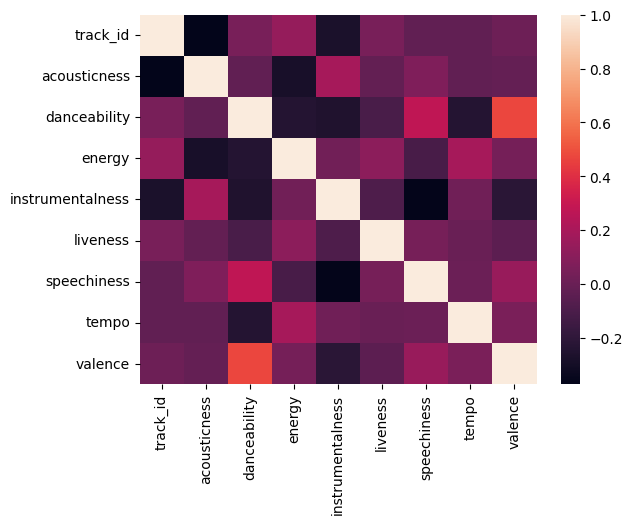

In [3]:
correlation_matrix = final_data.corr()
sns.heatmap(correlation_matrix)

In [4]:
num_columns = final_data.select_dtypes(include=['number'])

corr_metrics = num_columns.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


In [5]:
features = final_data.drop(['genre_top','track_id'], axis=1).values
print(features.shape)

labels = final_data['genre_top'].values
print(labels.shape)

train_features, test_features, train_labels, test_labels = train_test_split(features,labels,random_state=10)

(4802, 8)
(4802,)


In [6]:
scaler = StandardScaler()

# Scale train_features and test_features
scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)

Text(0.5, 0, 'Principal Component #')

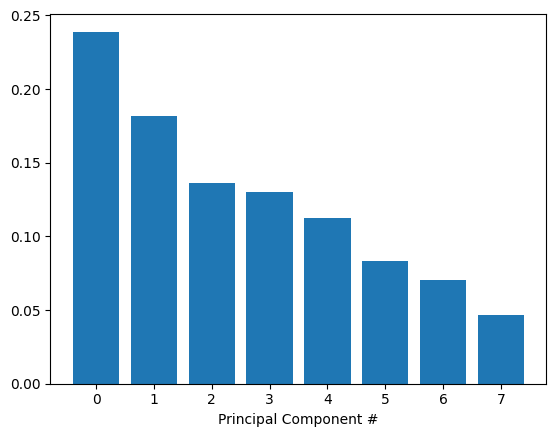

In [7]:
# This is just to make plots appear in the notebook
%matplotlib inline

pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

# using a bar plot
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')

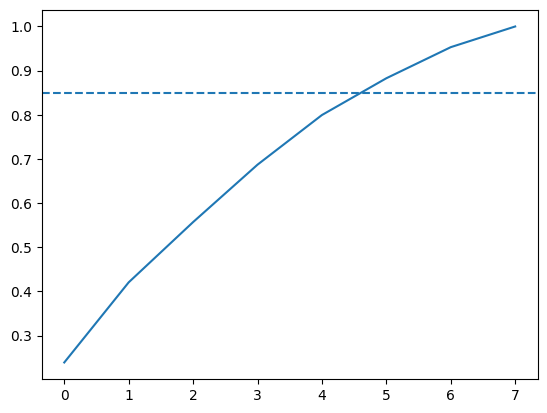

In [8]:
# the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.85.
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')

In [9]:
# Perform PCA and project data onto components
pca = PCA(n_components=6)

train_pca = pca.fit_transform(scaled_train_features)
print(train_pca.shape)

test_pca = pca.transform(scaled_test_features)
print(test_pca.shape)

(3601, 6)
(1201, 6)


In [10]:
dtree = DecisionTreeClassifier(random_state=10)
dtree.fit(train_pca,train_labels)
pred_labels_tree = dtree.predict(test_pca)

In [11]:
log_reg = LogisticRegression(random_state=10)
log_reg.fit(train_pca,train_labels)

pred_labels_logit = log_reg.predict(test_pca)

In [12]:
# classification report for pca and logistic regression
class_rep_dtree = classification_report(test_labels,pred_labels_tree)
class_rep_log = classification_report(test_labels,pred_labels_logit)

print("Decision Tree: \n", class_rep_dtree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.62      0.60      0.61       235
        Rock       0.90      0.91      0.91       966

    accuracy                           0.85      1201
   macro avg       0.76      0.76      0.76      1201
weighted avg       0.85      0.85      0.85      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.54      0.64       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201



In [13]:
# a balanced proportion of data points
hop_only = final_data.loc[final_data['genre_top'] == 'Hip-Hop']
rock_only = final_data.loc[final_data['genre_top'] == 'Rock']
print(hop_only.shape)
print(rock_only.shape)

(910, 10)
(3892, 10)


In [14]:
# subset only rock songs, take a sample the same size as hip-hop songs
rock_only = rock_only.sample(hop_only.shape[0], random_state=10)

# concatenate the dataframes
rock_hop_bal = pd.concat([rock_only, hop_only])

# The features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1)
labels = rock_hop_bal['genre_top']

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=10)

train_pca = pca.fit_transform(scaler.fit_transform(train_features))
test_pca = pca.transform(scaler.transform(test_features))

In [15]:
# Train our decision tree on the balanced data
dtree = DecisionTreeClassifier(random_state=10)
dtree.fit(train_pca,train_labels)
pred_labels_tree = dtree.predict(test_pca)

In [16]:
# Train our logistic regression on the balanced data
log_reg = LogisticRegression()
log_reg.fit(train_pca,train_labels)
pred_labels_logit = log_reg.predict(test_pca)

In [17]:
print("Decision Tree: \n", classification_report(test_labels,pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels,pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.82      0.77      0.79       230
        Rock       0.78      0.83      0.80       225

    accuracy                           0.80       455
   macro avg       0.80      0.80      0.80       455
weighted avg       0.80      0.80      0.80       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.80      0.82       230
        Rock       0.81      0.85      0.83       225

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.83      0.82      0.82       455



In [18]:
tree_pipe = Pipeline([("scaler", StandardScaler()),
                      ("pca", PCA(n_components=6)),
                      ("dtree", DecisionTreeClassifier(random_state=10))])
logreg_pipe = Pipeline([("scaler", StandardScaler()),
                        ("pca", PCA(n_components=6)),
                        ("log_reg", LogisticRegression(random_state=10))])

kf = KFold(10)

In [19]:
# train the models 
tree_score = cross_val_score(tree_pipe,features,labels,cv=kf)
logit_score = cross_val_score(logreg_pipe,features,labels,cv=kf)

# print the mean of the scores
print("Decision Tree:", tree_score.mean())
print("Logistic Regression:", logit_score.mean())

Decision Tree: 0.7598901098901099
Logistic Regression: 0.782967032967033
